# Decision Tree 

In [1]:
import numpy as np

# ml
from sklearn.model_selection import (
    KFold,
    cross_validate,
    GridSearchCV,
    RepeatedKFold,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics, get_ccp_scoring, print_results_table
from utils.datasets import load_and_split_data

In [2]:
# 设置显示中文字体

from pylab import mpl

mpl.rcParams["font.sans-serif"] = ["SimHei"]
# 设置正常显示符号
mpl.rcParams["axes.unicode_minus"] = False

data preprocessing

In [19]:
data_path = "../../data/processed/rdc_data_cleaned.csv"
X_raw, Y_raw = load_and_split_data(data_path, test_size=0.1, is_split=False)


scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(Y_raw)

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.1, random_state=42
)

# 打印划分后的数据集大小
print("训练集大小:", len(x_train))
print("测试集大小:", len(x_test))

训练集大小: 350
测试集大小: 39


## Single Training

In [11]:
x_train, x_test, y_train, y_test = load_and_split_data(data_path, test_size=0.1)

_model = DecisionTreeRegressor(criterion="absolute_error").fit(x_train, y_train)
calculate_metrics(
    _model.predict(x_test),
    y_test,
    print_metrics=True,
)

     CCP Predictive Modeling Metrics      
┏━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━━┓
┃ Feature │ MAE(Pa) │  MAPE   │ RMSE(Pa) ┃
┠─────────┼─────────┼─────────┼──────────┨
┃ Airflow │ 160.12  │ 12.24%  │  249.61  ┃
┃ Pres    │  13.49  │ 881.19% │  20.07   ┃
┗━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━━┛

## Single Training(scaled)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.1, random_state=42
)

_model = DecisionTreeRegressor(criterion="absolute_error").fit(x_train, y_train)
calculate_metrics(
    scaler_y.inverse_transform(_model.predict(scaler_x.transform(x_test))),
    y_test,
    print_metrics=True,
)

       CCP Predictive Modeling Metrics        
┏━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━━━━━┯━━━━━━━━━━┓
┃ Feature │ MAE(Pa) │    MAPE     │ RMSE(Pa) ┃
┠─────────┼─────────┼─────────────┼──────────┨
┃ Airflow │ 1613.82 │ 1873396.97% │ 1762.20  ┃
┃ Pres    │  12.91  │  7884.78%   │  16.17   ┃
┗━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━━━━━┷━━━━━━━━━━┛

保存模型

In [ ]:
# xgb.save_model("path")

In [ ]:
_model = DecisionTreeRegressor()

cv_mthd = RepeatedKFold(n_splits=5, n_repeats=3, random_state=44)
ccp_scoring = get_ccp_scoring()
results = cross_validate(_model, X=x_train, y=y_train, cv=cv_mthd, scoring=ccp_scoring)
print_results_table(results, ccp_scoring)

                         CCP Predictive Modeling Results                          
┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric       ┃ Mean     ┃ Fold 1   ┃ Fold 2   ┃ Fold 3   ┃ Fold 4   ┃ Fold 5   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ score        │ -2286.04 │ -1982.89 │ -3081.41 │ -1547.35 │ -2115.60 │ -2224.41 │
│ airflow_mae  │ -133.76  │ -130.37  │ -152.37  │ -117.56  │ -119.97  │ -135.81  │
│ airflow_rmse │ -197.91  │ -188.74  │ -233.16  │ -164.24  │ -179.45  │ -195.30  │
│ pres_mae     │ -12.09   │ -11.95   │ -11.78   │ -11.35   │ -12.71   │ -12.87   │
│ pres_rmse    │ -17.38   │ -17.34   │ -17.01   │ -15.66   │ -18.67   │ -18.19   │
└──────────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

## Grid Search

1. criterion

In [ ]:
model_name = "DT_criterion"
x_train, x_test, y_train, y_test = load_and_split_data(data_path, test_size=0.1)
grid_search = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid=[
        {
            "criterion": ["squared_error", "friedman_mse", "absolute_error"],
        },
    ],
    scoring=get_ccp_scoring(),
    refit="pres_rmse",
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
)
grid_search.fit(x_train, y_train)
calculate_metrics(
    grid_search.best_estimator_.predict(x_test),
    y_test,
    print_metrics=True,
    title=model_name,
)
print("Best Parameters for", model_name, ":", grid_search.best_params_)
print("Best Score for", model_name, ":", grid_search.best_score_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


               DT_criterion               
┏━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━━┓
┃ Feature │ MAE(Pa) │  MAPE   │ RMSE(Pa) ┃
┠─────────┼─────────┼─────────┼──────────┨
┃ Airflow │ 166.90  │ 12.81%  │  257.60  ┃
┃ Pres    │  13.71  │ 332.93% │  19.98   ┃
┗━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━━┛

Best Parameters for DT_criterion : {'criterion': 'absolute_error'}
Best Score for DT_criterion : -16.54290973444536


2. max_depth

粗粒度

最优参数以及最高得分: [    6.         -1820.71325575]


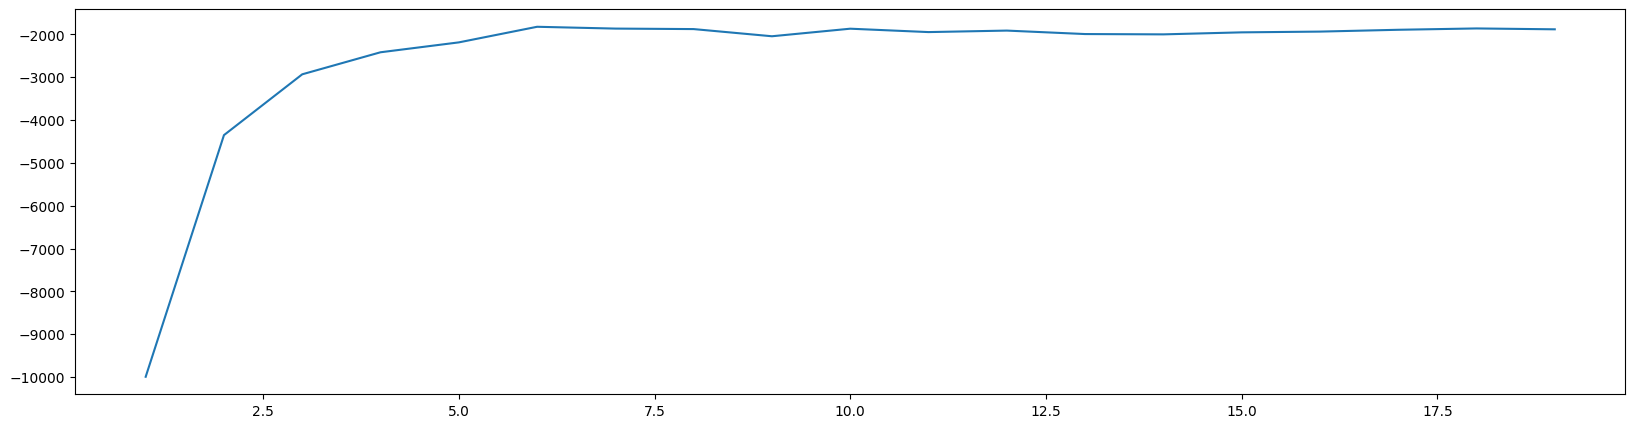

In [ ]:
###在大范围内画出max_depth这个参数变化曲线
ScoreAll = []
for i in range(1, 20):
    _DT_max_depth = DecisionTreeRegressor(max_depth=i, random_state=42)
    score = cross_validate(
        _DT_max_depth, x_train, y_train, scoring=get_ccp_scoring(), n_jobs=-1, cv=10
    )["test_score"].mean()
    ScoreAll.append([i, score])
ScoreAll = np.array(ScoreAll)
# 找出最高得分对应的索引
best_score = np.where(ScoreAll == np.max(ScoreAll[:, 1]))[0][0]
print("最优参数以及最高得分:", ScoreAll[best_score])

# print(ScoreAll[,0])
plt.figure(figsize=[20, 5])
plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
plt.show()

细粒度

最优参数以及最高得分: [    6.         -1820.71325575]


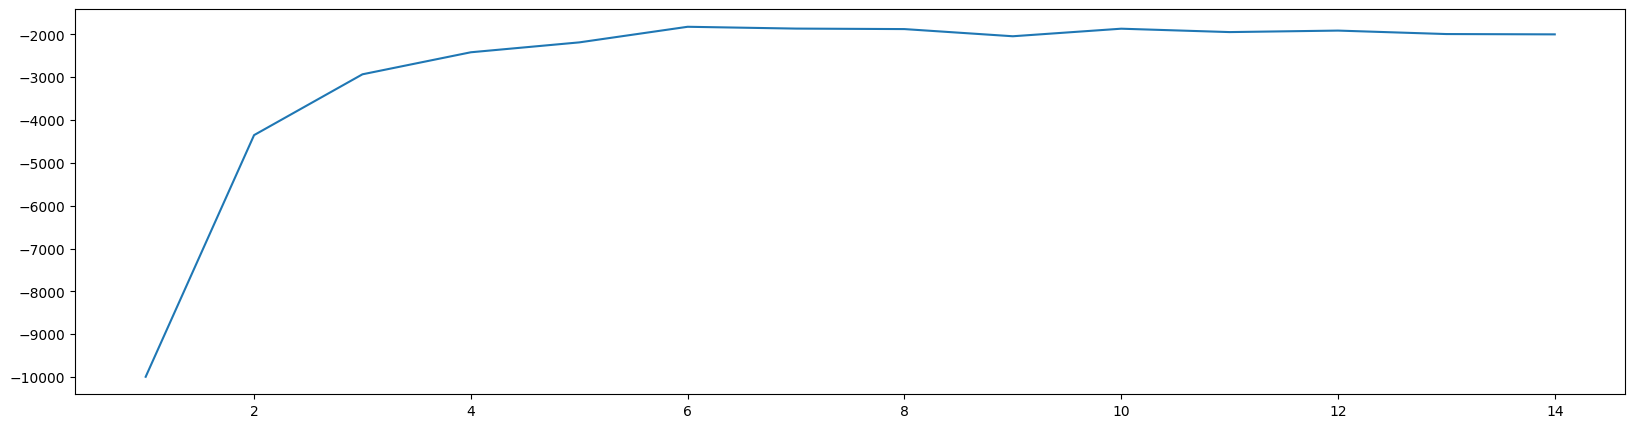

In [ ]:
###进一步缩小max_depth这个参数的范围
ScoreAll = []
for i in range(1, 15):
    _DT_max_depth = DecisionTreeRegressor(max_depth=i, random_state=42)
    score = cross_validate(
        _DT_max_depth, x_train, y_train, scoring=get_ccp_scoring(), n_jobs=-1, cv=10
    )["test_score"].mean()
    ScoreAll.append([i, score])
ScoreAll = np.array(ScoreAll)
# 找出最高得分对应的索引
best_score = np.where(ScoreAll == np.max(ScoreAll[:, 1]))[0][0]
print("最优参数以及最高得分:", ScoreAll[best_score])

# print(ScoreAll[,0])
plt.figure(figsize=[20, 5])
plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
plt.show()

3. min_samples_split

最优参数以及最高得分: [   19.         -1815.06877005]


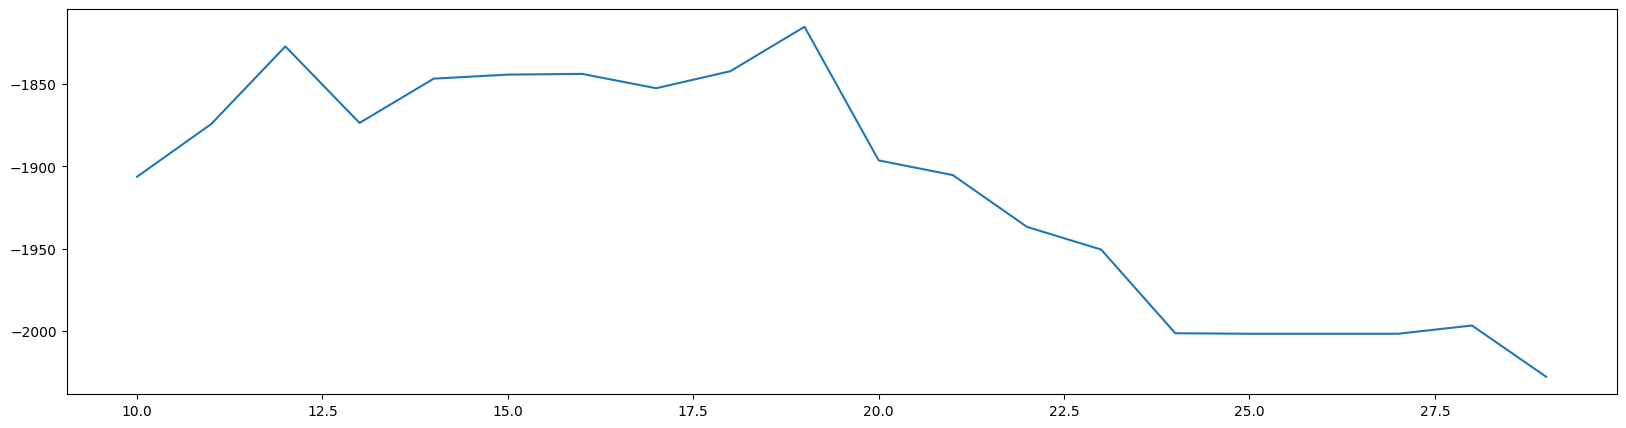

In [ ]:
ScoreAll = []
for i in range(10, 30):
    _DT_max_depth = DecisionTreeRegressor(
        max_depth=6, min_samples_split=i, random_state=42
    )
    score = cross_validate(
        _DT_max_depth, x_train, y_train, scoring=get_ccp_scoring(), n_jobs=-1, cv=10
    )["test_score"].mean()
    ScoreAll.append([i, score])
ScoreAll = np.array(ScoreAll)
# 找出最高得分对应的索引
best_score = np.where(ScoreAll == np.max(ScoreAll[:, 1]))[0][0]
print("最优参数以及最高得分:", ScoreAll[best_score])

# print(ScoreAll[,0])
plt.figure(figsize=[20, 5])
plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
plt.show()

Gird

In [ ]:
model_name = "DT"
x_train, x_test, y_train, y_test = load_and_split_data(data_path, test_size=0.1)
grid_search = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid=[
        {
            "criterion": ["squared_error"],
            "splitter": ["best", "random"],
            "max_depth": range(5, 15),
            "min_samples_split": range(5, 15),
        },
    ],
    scoring=get_ccp_scoring(),
    refit="pres_rmse",
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
)
grid_search.fit(x_train, y_train)
calculate_metrics(
    grid_search.best_estimator_.predict(x_test),
    y_test,
    print_metrics=True,
    title=model_name,
)
print("Best Parameters for", model_name, ":", grid_search.best_params_)
print("Best Score for", model_name, ":", grid_search.best_score_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


                    DT                    
┏━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━━┓
┃ Feature │ MAE(Pa) │  MAPE   │ RMSE(Pa) ┃
┠─────────┼─────────┼─────────┼──────────┨
┃ Airflow │ 141.96  │  9.94%  │  221.16  ┃
┃ Pres    │  11.95  │ 347.54% │  18.13   ┃
┗━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━━┛

Best Parameters for DT : {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 7, 'splitter': 'random'}
Best Score for DT : -14.412142689278975


保存模型

In [7]:
# xgb.save_model("path")

In [13]:
_model = DecisionTreeRegressor()

cv_mthd = RepeatedKFold(n_splits=5, n_repeats=3, random_state=44)
ccp_scoring = get_ccp_scoring()
results = cross_validate(_model, X=x_train, y=y_train, cv=cv_mthd, scoring=ccp_scoring)
print_results_table(results, ccp_scoring)

                         CCP Predictive Modeling Results                          
┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric       ┃ Mean     ┃ Fold 1   ┃ Fold 2   ┃ Fold 3   ┃ Fold 4   ┃ Fold 5   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ score        │ -2286.04 │ -1982.89 │ -3081.41 │ -1547.35 │ -2115.60 │ -2224.41 │
│ airflow_mae  │ -133.76  │ -130.37  │ -152.37  │ -117.56  │ -119.97  │ -135.81  │
│ airflow_rmse │ -197.91  │ -188.74  │ -233.16  │ -164.24  │ -179.45  │ -195.30  │
│ pres_mae     │ -12.09   │ -11.95   │ -11.78   │ -11.35   │ -12.71   │ -12.87   │
│ pres_rmse    │ -17.38   │ -17.34   │ -17.01   │ -15.66   │ -18.67   │ -18.19   │
└──────────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

# Grid Search(scaled)

In [30]:
model_name = "DT"
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.1, random_state=42
)
grid_search = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid=[
        {
            "criterion": ["squared_error", "friedman_mse", "absolute_error"],
            "splitter": ["best", "random"],
            "max_depth": range(5, 20),
            "min_samples_split": range(5, 15),
        },
    ],
    scoring="neg_mean_absolute_error",

    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
)
grid_search.fit(x_train, y_train)
calculate_metrics(
    scaler_y.inverse_transform(grid_search.best_estimator_.predict(x_test)),
    scaler_y.inverse_transform(y_test),
    print_metrics=True,
    title=model_name,
)
print("Best Parameters for", model_name, ":", grid_search.best_params_)
print("Best Score for", model_name, ":", grid_search.best_score_)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


                    DT                    
┏━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━━┓
┃ Feature │ MAE(Pa) │  MAPE   │ RMSE(Pa) ┃
┠─────────┼─────────┼─────────┼──────────┨
┃ Airflow │ 139.69  │  9.32%  │  209.34  ┃
┃ Pres    │  10.43  │ 790.67% │  15.30   ┃
┗━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━━┛

Best Parameters for DT : {'criterion': 'squared_error', 'max_depth': 18, 'min_samples_split': 8, 'splitter': 'best'}
Best Score for DT : -0.32911974026784085
